## Text Classification using Hierarchical Attention Networks
Implemented HAN on Amazon Reviews Dataset. Code for both generating as well as loading the models are present

## Mounting Google Drive

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


## 1. Loading the required libraries

In [2]:
import numpy as np

# To store data
import pandas as pd

# To open zipped files
import bz2

# To use regular expressions
import re

#To load and save data
import pickle

import os

os.environ['KERAS_BACKEND']='theano' # Or TenserFlow
from keras import initializers
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import *
from keras.models import Model
from keras.preprocessing.text import Tokenizer
from keras.engine.topology import Layer
from keras import initializers as initializers, regularizers, constraints
from keras.callbacks import Callback, ModelCheckpoint
from keras import backend as K
from keras.layers.core import Layer

from keras.models import model_from_json
from keras.models import load_model
import json

import matplotlib.pyplot as plt
from PIL import Image

Using Theano backend.


## Important Macros to be loaded before running any code

In [0]:
MAX_SENTENCES = 6 # Maximum number of sentences to be considered as a review for each sample
MAX_SENTENCE_LENGTH = 42 # Maximum number of words to be considered as a sentence for each sample
MAX_NB_WORDS = 8000 # This specifies how many top tokens in each review to be stored
EMBEDDING_DIM = 100

## Don't Run
## 2. Loading the preprocessed Data
* Load only if planning to prepare test and train data in blocks 4, 5 and 15


In [0]:
# Loading the train_x
!cp gdrive/My\ Drive/ADBI-Submission/Preprocessing/Data/preprocessed_train_review_sentences.pkl .
with open('preprocessed_train_review_sentences.pkl', 'rb') as f:
    train_reviews = pickle.load(f)

# Loading train_y
!cp gdrive/My\ Drive/ADBI-Submission/Preprocessing/Data/train_review_labels.pkl .
with open('train_review_labels.pkl', 'rb') as f:
    train_labels = pickle.load(f)

# Loading test_y
!cp gdrive/My\ Drive/ADBI-Submission/Preprocessing/Data/test_review_labels.pkl .
with open('test_review_labels.pkl', 'rb') as f:
    test_labels = pickle.load(f)

# Loading test_y
!cp gdrive/My\ Drive/ADBI-Submission/Preprocessing/Data/preprocessed_test_review_sentences.pkl .
with open('preprocessed_test_review_sentences.pkl', 'rb') as f:
    test_reviews = pickle.load(f)


## 3. Loading the embedding matrix and word_index generated from Tokenizer
#### Must run in order to both train as well as test the model

In [0]:
# Loading the word_embedding matrix
!cp gdrive/My\ Drive/ADBI-Submission/Preprocessing/Data/WordEmbeddingMappingMatrix.pkl .
with open('WordEmbeddingMappingMatrix.pkl', 'rb') as f:
    embedding_matrix = pickle.load(f)
    
# Loading the word_index
!cp gdrive/My\ Drive/ADBI-Submission/Preprocessing/Data/Word_Index.pkl .
with open('Word_Index.pkl', 'rb') as f:
    word_index = pickle.load(f)


## 4. Preparing the subset data for training the model
* Using only 1 million reviews.
* Shuffling the reviews before selecting
* Computing average sentence length and review length
* Takes time to run. 

In [0]:
# Training model only on a subset of data
from sklearn.utils import shuffle
from keras.preprocessing.text import text_to_word_sequence
x, y = shuffle(train_reviews, train_labels)

# Training on a subset of data, 1 million
train_x = x[:1000000]
train_y = y[:1000000]

review_len = 0
sentence_len = 0

for review  in x:
    sentences = review.split(".")
    review_len += len(sentences)
    for sentence in sentences:
        sentence_len += len(text_to_word_sequence(sentence))

#### Since average length of sentence is 42 we set max to 42.
#### Since an average review is of length 6, we consider max_sentence length as 6

In [0]:
print(int(review_len/ 3600000))
print(int(sentence_len / 3600000))

42
6


## Don't Run
## 5. Preparing Hierarchical structure of training data
* Generating document hierarchy takes time
* We have saved the train data
* Code for loading it is below

In [0]:
data = np.zeros((len(train_x), MAX_SENTENCES, MAX_SENTENCE_LENGTH))

for i, review in enumerate(train_x):
    sentences = review.split(".")
    for j, sentence in enumerate(sentences):
    # Number of sentences should be less than the maximum
        if j < MAX_SENTENCES:            
            wordTokens = text_to_word_sequence(sentence)
            k = 0
            for word in wordTokens:
                if k < MAX_SENTENCE_LENGTH and word_index[word] < MAX_NB_WORDS:
                    data[i, j, k] = word_index[word]
                    k += 1
train_x = data

## Don't *Run*
## 6. Saving the training data and the corresponding labels
* Only needs to be run if you have prepared the train data again

In [0]:
# Save the training data
with open('x_train_subset.pkl', 'wb') as f:
    pickle.dump(train_x, f)
! cp x_train_subset.pkl gdrive/My\ Drive/ADBI-Submission/HAN/Code/

# Saving training labels
with open('y_train_subset.pkl', 'wb') as f:
    pickle.dump(train_y, f)
! cp y_train_subset.pkl gdrive/My\ Drive/ADBI-Submission/HAN/Code/



## 7. Loading the training data and the corresponding labels

In [0]:
# Loading train_x
! cp gdrive/My\ Drive/ADBI-Submission/HAN/Code/x_train_subset.pkl .
with open('x_train_subset.pkl', 'rb') as f:
    train_x = pickle.load(f)
    
# Loading train_y
! cp gdrive/My\ Drive/ADBI-Submission/HAN/Code/y_train_subset.pkl .
with open('y_train_subset.pkl', 'rb') as f:
    train_y = pickle.load(f)

## *Run this*
## 8. Implementation of the Attention Layer

In [0]:
# Attention Layer
def dot_product(x, kernel):

    if K.backend() == 'tensorflow':
        # todo: check that this is correct
        return K.squeeze(K.dot(x, K.expand_dims(kernel)), axis=-1)
    else:
        return K.dot(x, kernel)


class Attention(Layer):
    def __init__(self,
                 W_regularizer=None, b_regularizer=None,
                 W_constraint=None, b_constraint=None,
                 bias=True,
                 return_attention=False,
                 **kwargs):

        self.supports_masking = True
        self.return_attention = return_attention
        self.init = initializers.get('glorot_uniform')

        self.W_regularizer = regularizers.get(W_regularizer)
        self.b_regularizer = regularizers.get(b_regularizer)

        self.W_constraint = constraints.get(W_constraint)
        self.b_constraint = constraints.get(b_constraint)

        self.bias = bias
        super(Attention, self).__init__(**kwargs)

    def build(self, input_shape):
        assert len(input_shape) == 3

        self.W = self.add_weight((input_shape[-1],),
                                 initializer=self.init,
                                 name='{}_W'.format(self.name),
                                 regularizer=self.W_regularizer,
                                 constraint=self.W_constraint)
        if self.bias:
            self.b = self.add_weight((input_shape[1],),
                                     initializer='zero',
                                     name='{}_b'.format(self.name),
                                     regularizer=self.b_regularizer,
                                     constraint=self.b_constraint)
        else:
            self.b = None

        self.built = True

    def compute_mask(self, input, input_mask=None):
        # do not pass the mask to the next layers
        return None

    def call(self, x, mask=None):
        eij = dot_product(x, self.W)

        if self.bias:
            eij += self.b

        eij = K.tanh(eij)

        a = K.exp(eij)

        # apply mask after the exp. will be re-normalized next
        if mask is not None:
            # Cast the mask to floatX to avoid float64 upcasting in theano
            a *= K.cast(mask, K.floatx())

        a /= K.cast(K.sum(a, axis=1, keepdims=True) + K.epsilon(), K.floatx())

        weighted_input = x * K.expand_dims(a)

        result = K.sum(weighted_input, axis=1)

        if self.return_attention:
            return [result, a]
        return result

    def compute_output_shape(self, input_shape):
        if self.return_attention:
            return [(input_shape[0], input_shape[-1]),
                    (input_shape[0], input_shape[1])]
        else:
            return input_shape[0], input_shape[-1]

## Don't *Run*
## 9. Model Architecture
* Do not run this as it takes several hours to build model
* Code for loading saved model is below

In [0]:
# Model architecture
embedding_layer = Embedding(len(word_index) + 1,
                            EMBEDDING_DIM,weights=[embedding_matrix],
                            input_length=MAX_SENTENCE_LENGTH,trainable=True)

# Words level attention model
word_input = Input(shape=(MAX_SENTENCE_LENGTH,), dtype='int32')
embedded_sequences = embedding_layer(word_input)
word_lstm = Bidirectional(GRU(128, return_sequences=True))(embedded_sequences)
word_dense = TimeDistributed(Dense(100))(word_lstm)
word_att = Attention()(word_dense)
wordEncoder = Model(word_input, word_att)

# Sentence level attention model
sent_input = Input(shape=(MAX_SENTENCES, MAX_SENTENCE_LENGTH), dtype='int32')
sent_encoder = TimeDistributed(wordEncoder)(sent_input)
sent_lstm = Bidirectional(GRU(128, return_sequences=True))(sent_encoder)
sent_dense = TimeDistributed(Dense(100))(sent_lstm)
sent_att = Dropout(0.5)(Attention()(sent_dense))
preds = Dense(1, activation='sigmoid')(sent_att)
model = Model(sent_input, preds)
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['acc'])
model.summary()

# Keeping a checkpoint to store only the model which gives best output validation accuracy
chkpt=ModelCheckpoint('HAN/Result/han_model.h5',monitor='val_acc',verbose=1,save_best_only=True)

model_history = model.fit(train_x, train_y, batch_size=1024, epochs=5, validation_split=0.1,callbacks=[chkpt])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 6, 42)             0         
_________________________________________________________________
time_distributed_8 (TimeDist (None, 6, 100)            99851514  
_________________________________________________________________
bidirectional_6 (Bidirection (None, 6, 256)            175872    
_________________________________________________________________
time_distributed_9 (TimeDist (None, 6, 100)            25700     
_________________________________________________________________
attention_6 (Attention)      (None, 100)               106       
_________________________________________________________________
dropout_3 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 101       
Total para

## Don't *Run*
## 10. Saving the model weights, architecture and history
* Needs to be run only you have trained model again

In [0]:
# Saving the model so that it can be loaded easily again
model.save('han_model.h5')
model.save_weights('han_model.h5')
!cp han_model.h5 gdrive/My\ Drive/HAN/Result/

# Save the model architecture
with open('han_model_architecture.json', 'w') as f:
    f.write(model.to_json())
!cp han_model_architecture.json gdrive/My\ Drive/HAN/Result/
    
# Saving model history
with open('history', 'wb') as f:
    pickle.dump(model_history, f)
!cp history gdrive/My\ Drive/HAN/Result/


## 11. Loading model and the history
* Run blocks 3, 6 and 8 first

In [0]:
# Loading the model
# Loading the History
embedding_layer = Embedding(len(word_index) + 1,
                            EMBEDDING_DIM,weights=[embedding_matrix],
                            input_length=MAX_SENTENCE_LENGTH,trainable=True)

# Words level attention model
word_input = Input(shape=(MAX_SENTENCE_LENGTH,), dtype='int32')
embedded_sequences = embedding_layer(word_input)
word_lstm = Bidirectional(GRU(128, return_sequences=True))(embedded_sequences)
word_dense = TimeDistributed(Dense(100))(word_lstm)
word_att = Attention()(word_dense)
wordEncoder = Model(word_input, word_att)

# Sentence level attention model
sent_input = Input(shape=(MAX_SENTENCES, MAX_SENTENCE_LENGTH), dtype='int32')
sent_encoder = TimeDistributed(wordEncoder)(sent_input)
sent_lstm = Bidirectional(GRU(128, return_sequences=True))(sent_encoder)
sent_dense = TimeDistributed(Dense(100))(sent_lstm)
sent_att = Dropout(0.5)(Attention()(sent_dense))
preds = Dense(1, activation='sigmoid')(sent_att)
model = Model(sent_input, preds)
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['acc'])

!cp gdrive/My\ Drive/ADBI-Submission/HAN/Result/han_model.h5 .
!cp gdrive/My\ Drive/ADBI-Submission/HAN/Result/history .

model.load_weights('han_model.h5')

# Loading the history used to generate accuracy and loss curves
with open('history', 'rb') as f:
        model_history = pickle.load(f)

## Don't *Run*
## 12. Generating Loss Curves

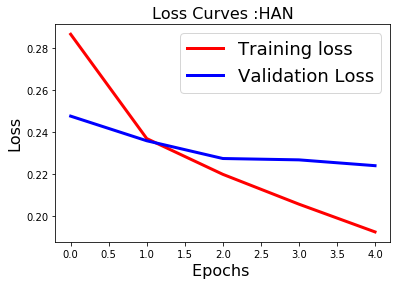

In [0]:
plt.switch_backend('agg')
%matplotlib inline

# Loss Curves
fig1 = plt.figure()
plt.plot(model_history['loss'],'r',linewidth=3.0)
plt.plot(model_history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves :HAN',fontsize=16)
plt.show()

## 13. Generating Accuracy Curves

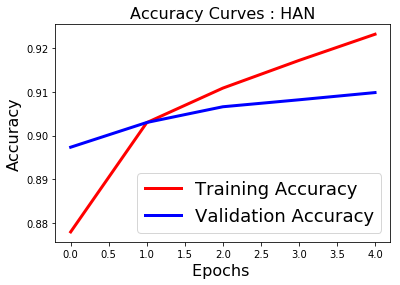

In [9]:
# Accuracy Curves
fig2=plt.figure()
plt.plot(model_history['acc'],'r',linewidth=3.0)
plt.plot(model_history['val_acc'],'b',linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves : HAN',fontsize=16)
plt.show()

## 14. Saving Accuracy and Loss Curves

In [0]:
# Saving the curves
fig1.savefig('loss_han.png')
!cp loss_han.png gdrive/My\ Drive/ADBI-Submission/HAN/Result/

fig2.savefig('accuracy_han.png')
!cp accuracy_han.png gdrive/My\ Drive/ADBI-Submission/HAN/Result/

## Don't *Run*

## 15. Preparing the data for test set
* Preparing hierarchical structure of the test set
* 0.4 million reviews in test set
* Generating it takes time, code for loading prepared test data is below

In [0]:
# Preparing data for test
x_test, test_y = shuffle(test_reviews, test_labels)

test_x = np.zeros((len(x_test), MAX_SENTENCES, MAX_SENTENCE_LENGTH))

for i, review in enumerate(x_test):
    sentences = review.split(".")
    for j, sentence in enumerate(sentences):
    # Number of sentences should be less than the maximum
        if j < MAX_SENTENCES:
            wordTokens = text_to_word_sequence(sentence)
            k = 0
            for word in wordTokens:
                try:
                    if k < MAX_SENTENCE_LENGTH and word_index[word] < MAX_NB_WORDS:
                        test_x[i, j, k] = word_index[word]
                        k += 1
                except:
                    continue


## Don't *Run*
## 16. Saving hierarchical test data and its labels

In [0]:
with open('x_test_subset.pkl', 'wb') as f:
    pickle.dump(test_x, f)   
!cp x_test_subset.pkl gdrive/My\ Drive/ADBI-Submission/HAN/Result/

with open('y_test_subset.pkl', 'wb') as f:
    pickle.dump(test_y, f)   
!cp y_test_subset.pkl gdrive/My\ Drive/ADBI-Submission/HAN/Result/

## 17. Loading prepared test data and its labels

In [0]:
# Loading the test_x
!cp gdrive/My\ Drive/ADBI-Submission/HAN/Code/x_test_subset.pkl .
with open('x_test_subset.pkl', 'rb') as f:
    test_x = pickle.load(f)

# Loading test_y
!cp gdrive/My\ Drive/ADBI-Submission/HAN/Code/y_test_subset.pkl .
with open('y_test_subset.pkl', 'rb') as f:
    test_y = pickle.load(f)

In [0]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 6, 42)             0         
_________________________________________________________________
time_distributed_5 (TimeDist (None, 6, 100)            99851514  
_________________________________________________________________
bidirectional_4 (Bidirection (None, 6, 256)            175872    
_________________________________________________________________
time_distributed_6 (TimeDist (None, 6, 100)            25700     
_________________________________________________________________
attention_4 (Attention)      (None, 100)               106       
_________________________________________________________________
dropout_2 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 101       
Total para

## 18. Evaluating the model

In [0]:
model.evaluate(test_x, test_y)

WARNING (theano.tensor.blas): We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.
WARNING (theano.tensor.blas): We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.


400000/400000 [==============================] - 3127s 8ms/step


[0.22167989933058618, 0.911085]

## 19. Generating the architecture plot of HAN

In [0]:
import pydot
from keras.utils import plot_model
plot_model(model, to_file='han_model_diagram.png',show_shapes=True, show_layer_names=True)
!cp han_model_diagram.png gdrive/My\ Drive/ADBI-Submission/HAN/Result/

## 20. Displaying the Model Architecture

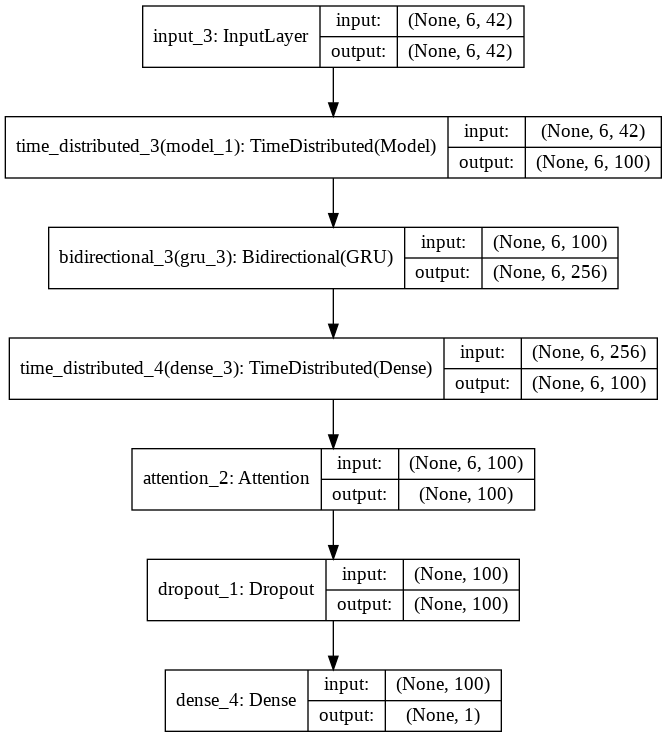

In [0]:
# Displaying visual graph of the CNN Model
!cp gdrive/My\ Drive/ADBI-Submission/HAN/Result/han_model_diagram.png .
display(Image.open('han_model_diagram.png'))